# Projet 8 - Déployer un modèle dans le cloud

La "Fruits!" cherche à proposer des solutions innovantes pour la récolte des fruits.

La volonté de l’entreprise est de préserver la biodiversité des fruits en permettant des traitements spécifiques pour chaque espèce de fruits en développant des robots cueilleurs intelligents.
La start-up souhaite dans un premier temps se faire connaître en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.<br>
Nous avons à disposition un fichier contenant deux dossiers :
- Image original
- Image redimensionné

Dans le dossier "image redimensionné" :
- Test
- test-multiple_fruits
- Training

Danns le dossier "image original":
- Test
- Training
- Validation

## Sommaire :
* [Importation des librairies](#chapter1)
* [Ouvertures des images](#chapter2)

## Importation des librairies <a class="anchor" id="chapter1"></a>

In [1]:
#Importation des librairies de bases
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Image
import os
from PIL import Image

## Ouverture image <a class="anchor" id="chapter1"></a>

Dans cette section, on prend le lien "training" et le but est d'afficher une image de chaque dossier. On récupère le nom de chacun des sous dossiers qu'on met dans la variable image. Ensuite, on affiche les premières images de chacun de ses sous dossiers.

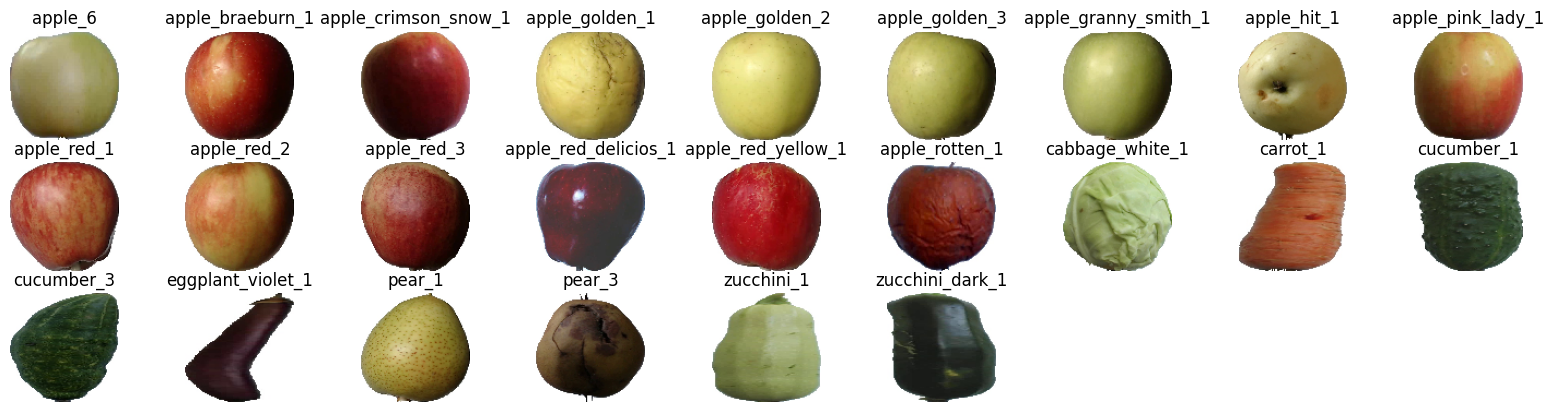

In [2]:
from tensorflow.keras.utils import img_to_array, load_img
# Le lien des images
path = "./archive/fruits-360-original-size/fruits-360-original-size/Training/"

# On récupère les noms de chacuns des sous-dossiers dans le fichier training.
# Pour un autre dossier, il suffit de changer de lien, tout est automatiser.
files = os.listdir(path)
images = []
for name in files:
    images.append(name)

# Les premières images de chaques sous dossier sont affiché, le noms est le même à chaque fois.
fig = plt.figure(figsize =(20,15))
for i in range(len(images)):
    ax = fig.add_subplot(9,9,i+1,xticks=[],yticks=[])
    plt.title(images[i])
    plt.axis("off")
    ax.imshow(load_img(path + images[i] +"/r0_0.jpg", target_size=(100,100)))

## PySpark

Dans cette section, on va travailler avec les images avec PySpark.

PySpark est une alternative plus puissante que Pandas Python. Il permet de faire des calculs en temps réel sur une grande quantité de données car il se concentre sur le traitement en mémoire. Il présente une faible latence.<br>
PySpark nous permet d’atteindre une grande vitesse de traitement des données, qui est environ 100 fois plus rapide en mémoire et 10 fois plus rapide sur le disque.

In [3]:
import pandas as pd
from PIL import Image
import numpy as np
import io

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from pyspark import SparkContext

On met les chemins dans les variables. Ici comme le travail se fait en local, on est donc limité en puissance, on va faire le travail sur deux fruits : les noix et les pastèques. Pour enregistrer nos résultats, on créait un nouveau dossier.

In [4]:
PATH = os.getcwd()
PATH_Data = PATH+'/archive/fruits-360_dataset/fruits-360/Image/'
PATH_Result = PATH+'/archive/fruits-360_dataset/fruits-360/Resultat/'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        c:\Users\lecou\Projet 8\Projet8
PATH_Data:   c:\Users\lecou\Projet 8\Projet8/archive/fruits-360_dataset/fruits-360/Image/
PATH_Result: c:\Users\lecou\Projet 8\Projet8/archive/fruits-360_dataset/fruits-360/Resultat/


In [5]:
import pyspark
from pyspark.sql import *
# La commande en dessous, permet de trouver exécutables dans le dossier SPARK_HOME
import findspark
findspark.init()

In [6]:
# Ici on affiche les liens ou sont stoké les données avec pour nom SPARK

for o, v in sorted(os.environ.items()):
    if "SPARK" in o.upper():
        print("{0:25}= {1}".format(o, v.replace(os.environ["USERNAME"], "<username>")))

PYSPARK_PYTHON           = C:\Users\<username>\AppData\Local\Programs\Python\Python310\python.exe
SPARK_HOME               = C:\Spark\spark-3.3.1-bin-hadoop3


Création de l'application SparkSession :
- on le créait en local sans spécifier le nombre de coeur,
- on lui fournit un nom
- "parquet" permet d'enregistrer et de charger le résultat du travail,
- getOCreate() créait le modèle

In [7]:
spark = SparkSession\
             .builder\
             .appName('P8')\
             .master('local')\
             .config("spark.sql.parquet.writeLegacyFormat", 'true')\
             .getOrCreate()

Résumé de notre modèle Spark

In [8]:
spark

On enregistre dans la variable sc, un sparkContext issue du spark.<br>
sparkContext est un point d'entrée vers Spark, il est utilisé pour créer des prograommes Spark RDD, des "accumulateurs et des variables de dissusion sur le cluster (qu'on appelle des broadcast variables).

In [9]:
sc = spark.sparkContext

On va préparer nos données, on va :
- Importer les images dans un dataframe pandas
- Associer aux images leur label
- Préprocesser en redimensionnant nos images pour qu'elles soient compatibles avec notre modèle

Avec spark.read, on va lire les images les deux fichiers d'images qu'on a sélectionné au début, on sélectionne tout les fichiers qui ont pour extensions ".jpg". On le met au format binaire ce qui offre plus de souplesse.

In [10]:
images = spark.read.format("binaryFile") \
                    .option("pathGlobFilter", "*.jpg") \
                    .option("recursiveFileLookup", "true") \
                    .load(PATH_Data)

Dans le code ci-dessous, on va créait un tableau avec :
- le chemin de l'image,
- l'heure de modification de l'image,
- la taille de l'image,
- son contenue et son label

Je ne vais qu'afficher en format tableau, le label et le chemin de l'image

In [11]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+----------------------------------------------------------------------------------------------------------+----------+
|path                                                                                                      |label     |
+----------------------------------------------------------------------------------------------------------+----------+
|file:/c:/Users/lecou/Projet 8/Projet8/archive/fruits-360_dataset/fruits-360/Image/Watermelon/r_106_100.jpg|Watermelon|
|file:/c:/Users/lecou/Projet 8/Projet8/archive/fruits-360_dataset/fruits-360/Image/Watermelon/r_109_100.jpg|Watermelon|
|file:/c:/Users/lecou/Projet 8/Projet8/archive/fruits-360_dataset/fruits-360/Image/Watermelon/r_108_100.jpg|Watermelon|
|file:/c:/Users/lecou/Projet 8/Projet8/archive/fruits-360_dataset/frui

On créait un modèle pour les images, on utilise la méthodes MobileNetV2. Un modèole plus rapide que VGG16.<br>
Nous chargeons le modèle MobileNetV2 avec les poids précalculés issus d'imagenet et en spécifiant le format de nos images en entrée. On retira la dernière couche du modèle.
- En entrée : l'entrée du modèle MobileNetV2
- En sortie : l'avant dernière couche du modèle MobileNetV2

In [12]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

Création du modèle

In [13]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

Résumée du modèle :

In [14]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

Lorsque vous exécutez un RDD Spark, des travaux DataFrame dont les variables de diffusion sont définies et utilisées, Spark effectue les opérations suivantes.<br>

- Spark décompose le travail en étapes qui ont distribué le brassage et les actions sont exécutées avec dans l'étape.
- Les étapes ultérieures sont également divisées en tâches
- Spark diffuse les données communes (réutilisables) nécessaires aux tâches de chaque étape.
- Les données diffusées sont mises en cache au format sérialisé et désérialisées avant l'exécution de chaque tâche.

In [15]:
brodcast_weights = sc.broadcast(new_model.get_weights())
brodcast_weights

La suite sera mis sous fonction

In [16]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

On utilise udf :
- pour créait une variable feature d'images en pd.Series,
- prétraiter les images.

In [17]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

c:\Users\lecou\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\pandas\functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


Maintenant que les fonctions sont écrit, on peut envoyer nos images pour créait notre tableau.

In [18]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )
features_df.show(5)
features_df.printSchema()

+--------------------+----------+--------------------+
|                path|     label|            features|
+--------------------+----------+--------------------+
|file:/c:/Users/le...|Watermelon|[0.18860376, 0.35...|
|file:/c:/Users/le...|Watermelon|[0.12481997, 0.02...|
|file:/c:/Users/le...|Watermelon|[0.0, 0.4021252, ...|
|file:/c:/Users/le...|Watermelon|[0.010176473, 0.1...|
|file:/c:/Users/le...|Watermelon|[0.0016466258, 0....|
+--------------------+----------+--------------------+
only showing top 5 rows

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



Nous avons maintement nos images, la colonne la plus importantes et la colonne "features". On va enregistrer maintenant nos données dans la dossier résultat.

In [19]:
print(PATH_Result)

c:\Users\lecou\Projet 8\Projet8/archive/fruits-360_dataset/fruits-360/Resultat/


Enregistrement des données traitées au format "parquet"

In [20]:
features_df.write.mode("overwrite").parquet(PATH_Result)

On lit notre nouveau tableau en format dataframe pandas.

In [21]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')
df.head(3)

,path,label,features
0,file:/c:/Users/lecou/Projet 8/Projet8/archive/...,Watermelon,"[0.18860376, 0.35067406, 0.06652797, 0.0, 0.64..."
1,file:/c:/Users/lecou/Projet 8/Projet8/archive/...,Watermelon,"[0.12481997, 0.026548162, 0.0, 0.0005343398, 0..."
2,file:/c:/Users/lecou/Projet 8/Projet8/archive/...,Watermelon,"[0.0, 0.4021252, 0.0, 0.0, 3.1078281, 0.274398..."


In [22]:
df.loc[0,'features'].shape

(1280,)

Par la suite, on va priviligier le dataframe au format pyspark pour faire notre calcul.<br>
Pour effectuer un PCA, on va :
- mettre au format vecteur la colonne "features",
- standaridiser les résultats,
- PCA

Format vecteur

In [23]:
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.sql.functions import udf
ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
tab = features_df.withColumn('features', ud_f('features'))
tab.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)



Standardisation

In [24]:
from pyspark.ml.feature import StandardScaler
standardizer = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                                  withStd=True, withMean=True)
model_std = standardizer.fit(tab)
tab = model_std.transform(tab)
tab.show(5)

+--------------------+----------+--------------------+--------------------+
|                path|     label|            features|      scaledFeatures|
+--------------------+----------+--------------------+--------------------+
|file:/c:/Users/le...|Watermelon|[0.18860375881195...|[0.30919978203981...|
|file:/c:/Users/le...|Watermelon|[0.12481997162103...|[0.05785633476515...|
|file:/c:/Users/le...|Watermelon|[0.0,0.4021252095...|[-0.4340034831859...|
|file:/c:/Users/le...|Watermelon|[0.01017647329717...|[-0.3939025423002...|
|file:/c:/Users/le...|Watermelon|[0.00164662580937...|[-0.4275148655367...|
+--------------------+----------+--------------------+--------------------+
only showing top 5 rows



PCA, on va tester pour choisir la meilleure dimension.

In [25]:
from pyspark.ml.feature import PCA
n_components = 250
pca = PCA(k=n_components, inputCol='scaledFeatures', outputCol='pcaFeatures')
model = pca.fit(tab)
tab_pca = model.transform(tab)

Text(0, 0.5, 'cumulative explained variance')

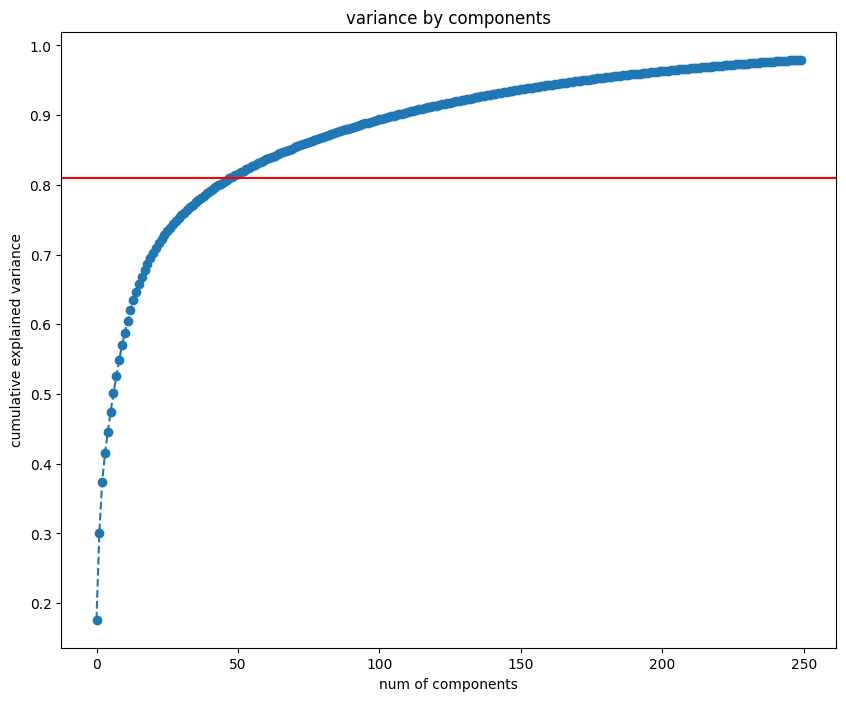

In [26]:
cumValues = model.explainedVariance.cumsum()
val_limite = 0.81
plt.figure(figsize=(10,8))
plt.plot(range(0,250), cumValues, marker = 'o', linestyle='--')
plt.axhline(y=val_limite, color='r', linestyle='-')
plt.title('variance by components')
plt.xlabel('num of components')
plt.ylabel('cumulative explained variance')

Choix de la dimension, en regardant 80% de la variance cumulée.

In [27]:
var = model.explainedVariance.cumsum()
print("Le nombre de dimension choisit est : ",var[var <=val_limite].shape[0])

Le nombre de dimension choisit est :  48


In [28]:
n_components = var[var <=val_limite].shape[0]
pca = PCA(k=n_components, inputCol='scaledFeatures', outputCol='pcaFeatures')
model_pca = pca.fit(tab)
tab = model_pca.transform(tab)
tab.show(5)
tab.printSchema()

+--------------------+----------+--------------------+--------------------+--------------------+
|                path|     label|            features|      scaledFeatures|         pcaFeatures|
+--------------------+----------+--------------------+--------------------+--------------------+
|file:/c:/Users/le...|Watermelon|[0.18860375881195...|[0.30919978203981...|[-15.726276160983...|
|file:/c:/Users/le...|Watermelon|[0.12481997162103...|[0.05785633476515...|[-13.572899655629...|
|file:/c:/Users/le...|Watermelon|[0.0,0.4021252095...|[-0.4340034831859...|[-13.469461791077...|
|file:/c:/Users/le...|Watermelon|[0.01017647329717...|[-0.3939025423002...|[-22.494152565864...|
|file:/c:/Users/le...|Watermelon|[0.00164662580937...|[-0.4275148655367...|[-16.635492921577...|
+--------------------+----------+--------------------+--------------------+--------------------+
only showing top 5 rows

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (n

Pour enregistrer au format csv, on va convertir, les colonnes de vecteur en string

In [29]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, StructType, StructField, IntegerType

def array_to_string(my_list):
    return '[' + ','.join([str(elem) for elem in my_list]) + ']'

array_to_string_udf = udf(array_to_string, StringType())

df_1 = tab.withColumn('features', array_to_string_udf(tab["features"]))
df_1 = df_1.withColumn('scaledFeatures', array_to_string_udf(df_1["scaledFeatures"]))
df_1 = df_1.withColumn('pcaFeatures', array_to_string_udf(df_1["pcaFeatures"]))
df_1.show(5)
df_1.printSchema()

+--------------------+----------+--------------------+--------------------+--------------------+
|                path|     label|            features|      scaledFeatures|         pcaFeatures|
+--------------------+----------+--------------------+--------------------+--------------------+
|file:/c:/Users/le...|Watermelon|[0.18860375881195...|[0.30919978203981...|[-15.726276160983...|
|file:/c:/Users/le...|Watermelon|[0.12481997162103...|[0.05785633476515...|[-13.572899655629...|
|file:/c:/Users/le...|Watermelon|[0.0,0.4021252095...|[-0.4340034831859...|[-13.469461791077...|
|file:/c:/Users/le...|Watermelon|[0.01017647329717...|[-0.3939025423002...|[-22.494152565864...|
|file:/c:/Users/le...|Watermelon|[0.00164662580937...|[-0.4275148655367...|[-16.635492921577...|
+--------------------+----------+--------------------+--------------------+--------------------+
only showing top 5 rows

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: string (n

Faire parquet <br>
Enregistrement, en fichier csv.

In [30]:
df_1.write.mode("overwrite").parquet("Features")

In [31]:
df_2 = pd.read_parquet("Features", engine='pyarrow')
df_2.head(3)

,path,label,features,scaledFeatures,pcaFeatures
0,file:/c:/Users/lecou/Projet 8/Projet8/archive/...,Watermelon,"[0.18860375881195068,0.3506740629673004,0.0665...","[0.30919978203981924,0.07508098674916365,-0.23...","[-15.726276160983618,-15.766287835829212,0.660..."
1,file:/c:/Users/lecou/Projet 8/Projet8/archive/...,Watermelon,"[0.12481997162103653,0.02654816210269928,0.0,0...","[0.05785633476515677,-0.8221042470742155,-0.47...","[-13.572899655629737,-24.09034068870922,8.9631..."
2,file:/c:/Users/lecou/Projet 8/Projet8/archive/...,Watermelon,"[0.0,0.40212520956993103,0.0,0.0,3.10782814025...","[-0.4340034831859764,0.2174985130006226,-0.477...","[-13.46946179107736,5.814978535981403,-6.67154..."


In [33]:
df_2.to_csv("Features.csv")